## **Feature Engineering Overview**
This pipeline prepares a **trial-level multimodal dataset** for predicting correctness in mental rotation tasks. It integrates EEG, Eye, IVT, GSR, and TIVA features per trial per participant.

### **Inputs**
- **EEG.csv:** Brainwave features (Delta, Theta, Alpha, Beta, Gamma bands)
- **EYE.csv + IVT.csv:** Eye-tracking and saccade/fixation features
- **GSR.csv:** Skin conductance and physiological arousal metrics
- **TIVA.csv:** Facial expressions and affective/emotion metrics
- **PSY.csv:** Target labels (`verdict` Correct/Incorrect) and trial timestamps

### **Steps Performed**
1. **Data Alignment**
   - Convert timestamps to milliseconds for all modalities.
   - Slice each modality per trial using `routineStart` and `routineEnd` from PSY.csv.
   - Each trial becomes one row with all modality features.

2. **Feature Computation**
   - **EEG:** Mean, standard deviation, and cognitive ratios (Beta/Alpha, Theta/Beta)
   - **Eye:** Mean pupil size, fixation count, gaze dispersion
   - **IVT:** Mean fixation duration, mean saccade amplitude, fixation/saccade counts
   - **GSR:** Mean, max, standard deviation, peak count
   - **TIVA:** Mean and max of emotions, engagement, attention, blink rate

3. **Feature Cleaning and Scaling**
   - Remove irrelevant or redundant features.
   - Handle missing values (NaN) consistently across modalities.
   - Perform scaling/normalization to ensure features are on a similar range, improving model stability.
   - Add engineered features like cognitive ratios, combined eye metrics, or aggregated facial metrics to enhance predictive power.

4. **Label Encoding**
   - `Correct = 1`, `Incorrect = 0`
   - Balance dataset using undersampling or SMOTE if class imbalance exists.

5. **Trial-Level Dataset**
   - Each row represents a single trial (sample)
   - Total samples: **38 participants × Questions**
   - All features aligned, cleaned, and scaled for downstream modeling.

### **Purpose & Usefulness**
- Produces a **consistent, ready-to-use multimodal dataset** for machine learning.
- Enables **baseline models (Random Forest, XGBoost), intermediate fusion, or advanced deep learning (LSTM, Transformer)**.
- Retains temporal alignment and cross-modality relationships.
- Facilitates feature importance analysis, selection, and interpretable modeling for predicting mental rotation correctness.

### **Outcome**
- Final merged and processed dataset: `Complete_Preprocessed.csv`
- Supports **EDA, model building, and experimentation** with multimodal signals.


## **Libraries and Imports**

These libraries are used for preprocessing, feature engineering, and visualization:

- `os` — handle file paths and directories.
- `pandas` — read, manipulate, and save tabular data (CSV files).
- `numpy` — numerical operations, array handling, and statistics.
- `matplotlib.pyplot` — basic plotting and figure creation.
- `seaborn` — statistical plotting and visualization (built on matplotlib).
- `sklearn.preprocessing.LabelEncoder` — encode categorical labels into numeric format.

**Purpose:** These imports provide the foundation for reading raw data, preprocessing it, encoding labels, and visualizing features for exploratory data analysis and feature engineering.


In [6]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [7]:
INPUT_DIR = "/content/drive/MyDrive/IITBinternship/Finalpreprocess"
OUTPUT_DIR = "/content/drive/MyDrive/IITBinternship/FinalFeatureEngineering"
os.makedirs(OUTPUT_DIR, exist_ok=True)


## **PSY_features_engineered.csv**
This file contains **per-trial psychological metadata** with cleaned, encoded features suitable for multimodal modeling of mental rotation task correctness.

### **Features**
- `Participant_ID` — unique identifier per participant
- `Result` — binary target (1 = Correct, 0 = Incorrect); trials without a response are **kept as NaN** to preserve the time sequence for future model development
- `Difficulty` — encoded difficulty of the question (0 = Easy, 1 = Medium, 2 = Difficult)
- `Category` — numeric category ID for question type

### **Engineering Steps**
1. **Drop unnecessary columns**
   - Removed `QuestionNumber` as it duplicates the `Key` feature.
2. **Rename and Encode Target**
   - Renamed `verdict` → `Result`
   - Encode: Correct = 1, Incorrect = 0
   - **Null values are retained** instead of dropping, to maintain the temporal sequence of trials.
3. **Encode Difficulty**
   - Missing `Difficulty` per participant filled with mode
   - Mapped string labels to numeric codes: Easy = 0, Medium = 1, Difficult = 2
4. **Convert Category**
   - Ensured numeric type for `Category` to support modeling
5. **Save Cleaned File**
   - Output: `PSY_features_engineered.csv` with consistent, model-ready features

### **Purpose**
- Provides **trial-level target and metadata** for multimodal modeling.
- Preserves temporal sequence by retaining skipped/null trials.
- Standardizes categorical information and encodes target for modeling.


In [3]:
psy_file = "PSY_features.csv"
psy_input_path = os.path.join(INPUT_DIR, psy_file)
psy_output_path = os.path.join(OUTPUT_DIR, "PSY_features_engineered.csv")

psy_df = pd.read_csv(psy_input_path, low_memory=False)

if 'QuestionNumber' in psy_df.columns:
    psy_df = psy_df.drop(columns=['QuestionNumber'])

psy_df = psy_df.rename(columns={'verdict': 'Result'})

psy_df['Result'] = psy_df['Result'].astype(str).str.strip().str.upper()
psy_df.loc[psy_df['Result'].isin(['NAN','NONE','NA']), 'Result'] = pd.NA
psy_df['Result'] = psy_df['Result'].map({'CORRECT': 1, 'INCORRECT': 0})

psy_df['Difficulty'] = psy_df.groupby('Participant_ID')['Difficulty'] \
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))

difficulty_map = {'EASY': 0, 'MEDIUM': 1, 'DIFFICULT': 2}
psy_df['Difficulty'] = psy_df['Difficulty'].astype(str).str.strip().str.upper()
psy_df['Difficulty'] = psy_df['Difficulty'].map(difficulty_map)

psy_df['Category'] = pd.to_numeric(psy_df['Category'], errors='coerce')

psy_df.to_csv(psy_output_path, index=False)
print(f"PSY engineered file saved: {psy_df.shape}")
display(psy_df.head(50))
display(psy_df.info())


PSY engineered file saved: (1448, 10)


,Key,Participant_ID,Category,Difficulty,ResponseTime,routineStart,routineEnd,Result,Start_ms,End_ms
0,1spl1,1,1,0,10.369816,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
1,1spl2,1,1,0,7.913991,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
2,1Item1,1,1,0,7.654472,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
3,1Item2,1,1,0,14.597205,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
4,1Item3,1,1,0,16.476565,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
5,1Item4,1,1,1,17.546052,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
6,1Item5,1,1,1,26.044480,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
7,1Item6,1,1,1,8.765435,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
8,1Item7,1,1,2,8.898406,1.680003e+09,1.680003e+09,1.0,1.680003e+12,1.680003e+12
9,1Item8,1,1,2,16.455400,1.680003e+09,1.680003e+09,0.0,1.680003e+12,1.680003e+12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Key             1448 non-null   object 
 1   Participant_ID  1448 non-null   int64  
 2   Category        1448 non-null   int64  
 3   Difficulty      1448 non-null   int64  
 4   ResponseTime    1448 non-null   float64
 5   routineStart    1448 non-null   float64
 6   routineEnd      1448 non-null   float64
 7   Result          1373 non-null   float64
 8   Start_ms        1448 non-null   float64
 9   End_ms          1448 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 113.3+ KB


None

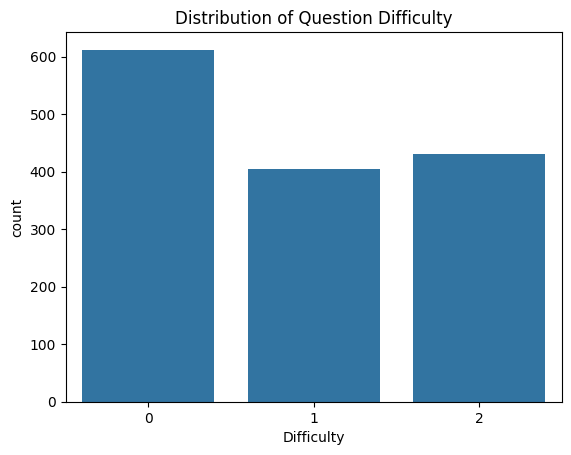

In [9]:
# Distribution of Result (Correct / Incorrect / NA)
sns.countplot(x='Difficulty', data=psy_df)
plt.title("Distribution of Question Difficulty")
plt.show()


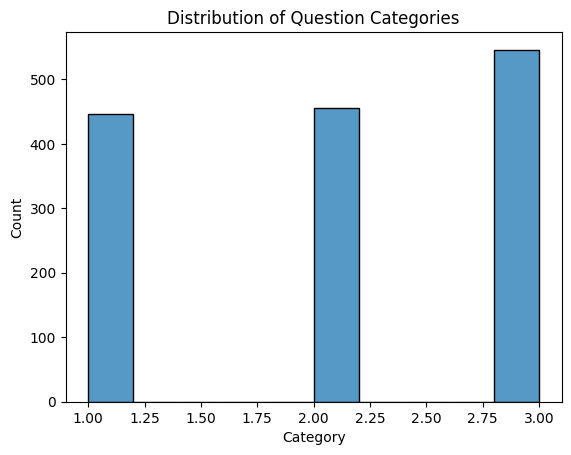

In [10]:
# 3. Distribution of Category
sns.histplot(psy_df['Category'].dropna(), bins=10, kde=False)
plt.title("Distribution of Question Categories")
plt.xlabel("Category")
plt.show()

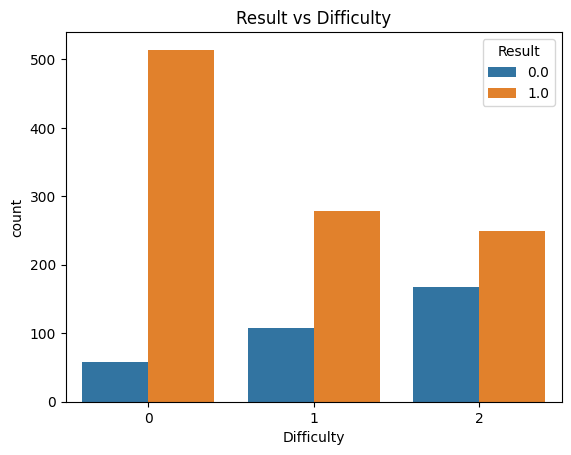

In [12]:
# Result vs Difficulty
sns.countplot(x='Difficulty', hue='Result', data=psy_df)
plt.title("Result vs Difficulty")
plt.show()

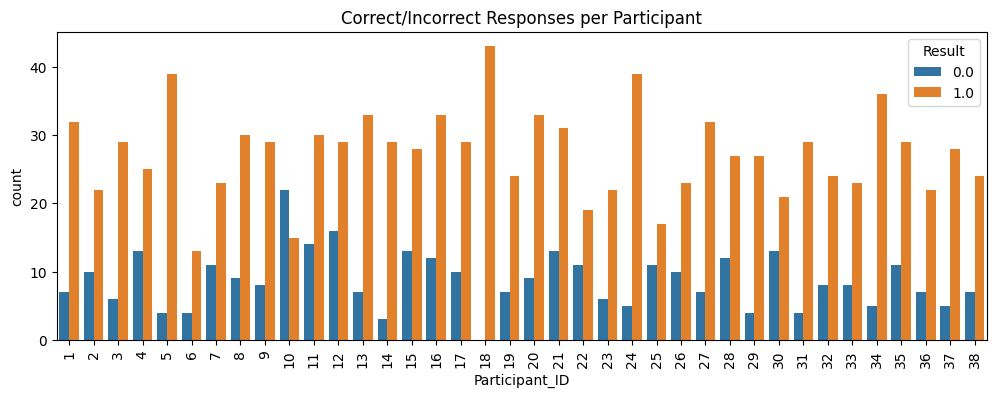

In [14]:
# Result per Participant
plt.figure(figsize=(12,4))
sns.countplot(x='Participant_ID', hue='Result', data=psy_df)
plt.title("Correct/Incorrect Responses per Participant")
plt.xticks(rotation=90)
plt.show()

/tmp/ipython-input-3694748162.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


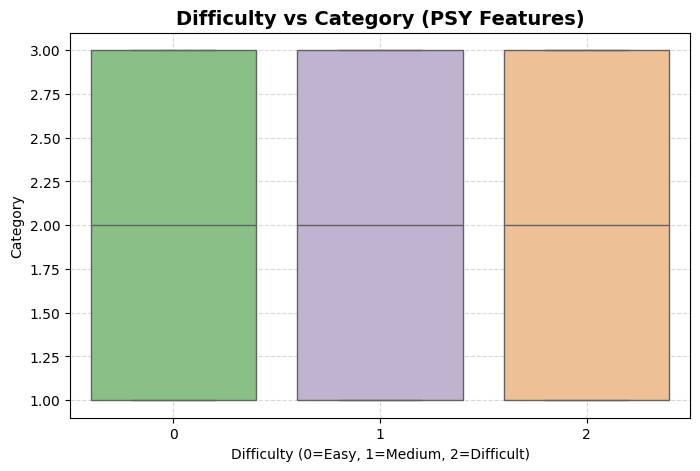

In [17]:
# Difficulty vs Category Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(
    x='Difficulty',
    y='Category',
    data=psy_df,
    palette=['#7FC97F', '#BEAED4', '#FDC086']  # Green, Purple, Orange for Easy, Medium, Difficult
)
plt.title("Difficulty vs Category (PSY Features)", fontsize=14, weight='bold')
plt.xlabel("Difficulty (0=Easy, 1=Medium, 2=Difficult)")
plt.ylabel("Category")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## **EEG_features_engineered.csv**

EEG_features_engineered.csv contains per-trial EEG metrics that are cleaned, imputed, and outlier-handled, aligned with each question window. These features are used for multimodal prediction of mental rotation task correctness.

### Features
- **Mean power per band:** Delta, Theta, Alpha, Beta, Gamma — captures overall brain activity.
- **Standard deviation per band:** Theta, Alpha, Beta — measures trial variability.
- **Cognitive ratios:** Beta/Alpha (focused thinking), Theta/Beta (attention control).

### Steps performed
1. **Load original EEG_features.csv.**
2. **Replace invalid values:** Convert `inf` and `-inf` to `NaN`.
3. **Impute missing values:**
   - Fill missing values **participant-wise** using median to preserve individual EEG patterns.
   - Fill any remaining NaNs with **global median** across all participants to maintain dataset consistency and avoid bias.
4. **Winsorize outliers:** Clip numeric values to the 1st–99th percentile per participant to reduce extreme fluctuations.
5. **Save processed EEG file** as `EEG_features_engineered.csv`.

### Why this is important
- EEG data often contains missing segments or extreme fluctuations; using raw data can bias models.
- Participant-specific median preserves **individual variability**.
- Global median ensures **no missing values remain**, which is essential for most machine learning models.
- Outlier clipping reduces skewness while **retaining valuable information**.
- Ensures reliable and consistent features for **multimodal modeling** (EEG + Eye + GSR + TIVA).




In [18]:
eeg_file = "EEG_features.csv"
eeg_input_path = os.path.join(INPUT_DIR, eeg_file)
eeg_output_path = os.path.join(OUTPUT_DIR, "EEG_features_engineered.csv")
eeg_df = pd.read_csv(eeg_input_path, low_memory=False)

eeg_df.replace([np.inf, -np.inf], np.nan, inplace=True)

numeric_cols = eeg_df.select_dtypes(include=[np.number]).columns.difference(['Participant_ID'])

def fill_groupwise_median(group):
    return group.fillna(group.median())

eeg_df[numeric_cols] = eeg_df.groupby("Participant_ID")[numeric_cols].transform(fill_groupwise_median)

eeg_df[numeric_cols] = eeg_df[numeric_cols].fillna(eeg_df[numeric_cols].median())

for col in numeric_cols:
    lower = eeg_df.groupby("Participant_ID")[col].transform(lambda x: x.quantile(0.01))
    upper = eeg_df.groupby("Participant_ID")[col].transform(lambda x: x.quantile(0.99))
    eeg_df[col] = np.clip(eeg_df[col], lower, upper)

eeg_df.to_csv(eeg_output_path, index=False)
eeg_df.info()
print(f"EEG engineered file saved: {eeg_df.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1448 non-null   object 
 1   Participant_ID        1448 non-null   int64  
 2   Start_ms              1448 non-null   float64
 3   End_ms                1448 non-null   float64
 4   eeg_mean_delta        1448 non-null   float64
 5   eeg_mean_theta        1448 non-null   float64
 6   eeg_mean_alpha        1448 non-null   float64
 7   eeg_mean_beta         1448 non-null   float64
 8   eeg_mean_gamma        1448 non-null   float64
 9   eeg_std_theta         1448 non-null   float64
 10  eeg_std_alpha         1448 non-null   float64
 11  eeg_std_beta          1448 non-null   float64
 12  eeg_beta_alpha_ratio  1448 non-null   float64
 13  eeg_theta_beta_ratio  1448 non-null   float64
dtypes: float64(12), int64(1), object(1)
memory usage: 158.5+ KB
EEG engineer

In [ ]:
eeg_df.head()

,Key,Participant_ID,Start_ms,End_ms,eeg_mean_delta,eeg_mean_theta,eeg_mean_alpha,eeg_mean_beta,eeg_mean_gamma,eeg_std_theta,eeg_std_alpha,eeg_std_beta,eeg_beta_alpha_ratio,eeg_theta_beta_ratio
0,1spl1,1,1.680003e+12,1.680003e+12,0.278648,0.172660,0.407933,0.266589,-0.208875,0.068551,0.093391,0.048627,0.653511,0.647664
1,1spl2,1,1.680003e+12,1.680003e+12,0.709148,0.405859,0.589369,0.322827,-0.059350,0.233898,0.220817,0.072398,0.547750,1.257203
2,1Item1,1,1.680003e+12,1.680003e+12,0.854009,0.528035,0.683743,0.366046,-0.103277,0.280163,0.169641,0.064204,0.535355,1.442539
3,1Item2,1,1.680003e+12,1.680003e+12,0.838483,0.515508,0.710686,0.297257,-0.144607,0.147355,0.140773,0.041330,0.418268,1.734214
4,1Item3,1,1.680003e+12,1.680003e+12,0.794340,0.446872,0.633282,0.308072,-0.158587,0.158837,0.151023,0.060047,0.486469,1.450542


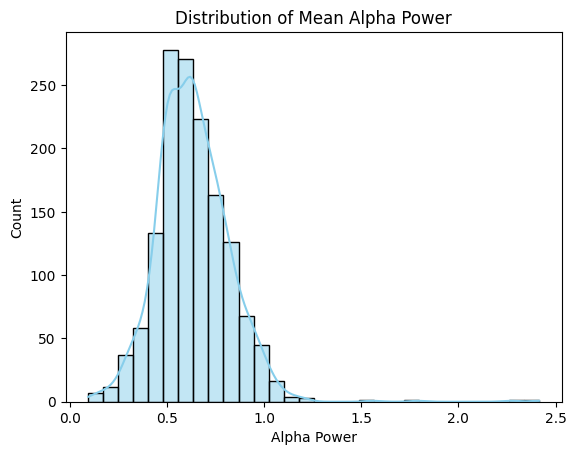

In [20]:
# Distribution of mean Alpha power
sns.histplot(eeg_df['eeg_mean_alpha'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Mean Alpha Power")
plt.xlabel("Alpha Power")
plt.ylabel("Count")
plt.show()

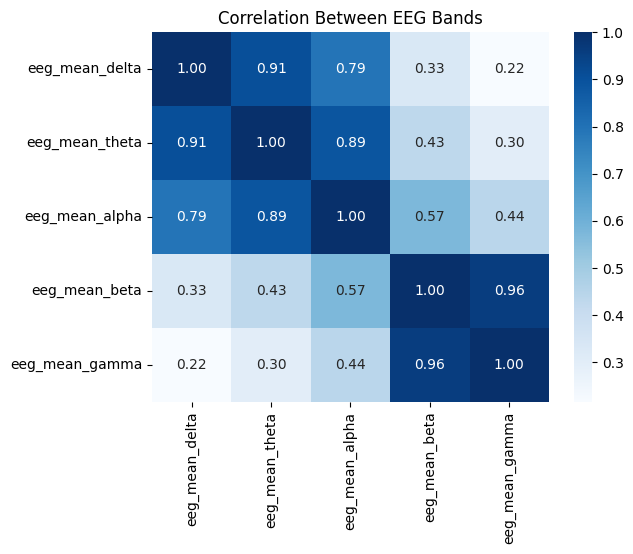

In [22]:
# Correlation heatmap between EEG bands
sns.heatmap(
    eeg_df[['eeg_mean_delta','eeg_mean_theta','eeg_mean_alpha','eeg_mean_beta','eeg_mean_gamma']].corr(),
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title("Correlation Between EEG Bands")
plt.show()


## **Eye_features_engineered.csv**

`Eye_features_engineered.csv` contains per-trial eye-tracking metrics aligned with each question window. These features will be used for multimodal prediction of mental rotation task correctness.

**Features:**
- `eye_mean_pupil` — average pupil size per trial (left + right), reflecting cognitive load.
- `eye_fixation_count` — total number of recorded fixations during the trial, indicating visual attention.
- `eye_gaze_dispersion` — average distance between left and right gaze points, capturing scanning behavior.

**Steps performed:**
1. Load the original `Eye_features.csv`.
2. Convert `eye_fixation_count` to float for numerical consistency.
3. Retain all trials, even if some pupil or gaze values are missing (NaN), to preserve time sequence for modeling.
4. Save as `Eye_features_engineered.csv`.

**Why this is important:**
- Eye-tracking data often has missing points due to tracking loss; filling or dropping could break temporal sequence.
- Converting counts to float ensures proper numeric operations during modeling.
- Keeps trial-level alignment for **EEG + GSR + TIVA** integration in multimodal models.




In [25]:
eye_file = "Eye_features.csv"
eye_input_path = os.path.join(INPUT_DIR, eye_file)
eye_output_path = os.path.join(OUTPUT_DIR, "EYE_features_engineered.csv")

eye_df = pd.read_csv(eye_input_path, low_memory=False)

if 'eye_fixation_count' in eye_df.columns:
    eye_df['eye_fixation_count'] = eye_df['eye_fixation_count'].astype(float)

eye_df.to_csv(eye_output_path, index=False)
print(f"EYE engineered file saved: {eye_df.shape}")
display(eye_df.head(10))
display(eye_df.info())

EYE engineered file saved: (1448, 7)


,Key,Participant_ID,Start_ms,End_ms,eye_mean_pupil,eye_fixation_count,eye_gaze_dispersion
0,1spl1,1,1.680003e+12,1.680003e+12,0.188283,1200.0,126.931819
1,1spl2,1,1.680003e+12,1.680003e+12,0.246257,960.0,106.617668
2,1Item1,1,1.680003e+12,1.680003e+12,0.225902,960.0,114.222372
3,1Item2,1,1.680003e+12,1.680003e+12,0.206350,1680.0,128.769764
4,1Item3,1,1.680003e+12,1.680003e+12,0.037860,1920.0,180.514247
5,1Item4,1,1.680003e+12,1.680003e+12,0.121718,2160.0,130.452359
6,1Item5,1,1.680003e+12,1.680003e+12,0.197517,3121.0,125.108997
7,1Item6,1,1.680003e+12,1.680003e+12,0.132258,960.0,143.364540
8,1Item7,1,1.680003e+12,1.680003e+12,0.073601,1080.0,164.728861
9,1Item8,1,1.680003e+12,1.680003e+12,0.099956,2040.0,149.591792


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Key                  1448 non-null   object 
 1   Participant_ID       1448 non-null   int64  
 2   Start_ms             1448 non-null   float64
 3   End_ms               1448 non-null   float64
 4   eye_mean_pupil       1448 non-null   float64
 5   eye_fixation_count   1448 non-null   float64
 6   eye_gaze_dispersion  1448 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 79.3+ KB


None

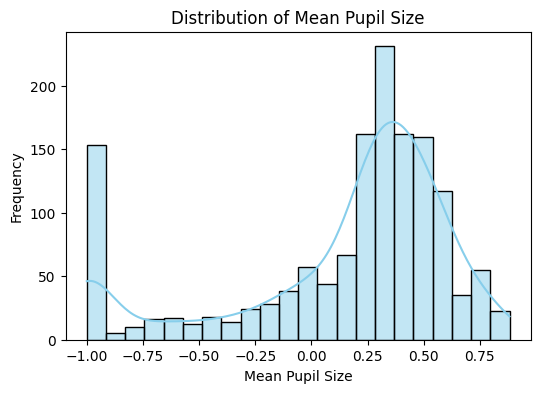

In [29]:
# Distribution of Mean Pupil Size
plt.figure(figsize=(6,4))
sns.histplot(eye_df['eye_mean_pupil'].dropna(), kde=True, color='skyblue')
plt.title("Distribution of Mean Pupil Size")
plt.xlabel("Mean Pupil Size")
plt.ylabel("Frequency")
plt.show()


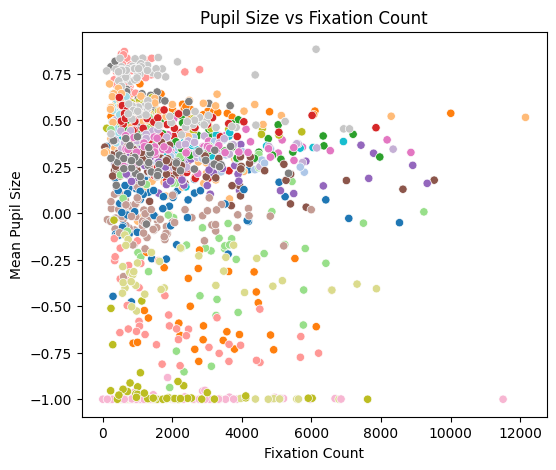

In [30]:
# Scatter Plot: Pupil Size vs Fixation Count
plt.figure(figsize=(6,5))
sns.scatterplot(x='eye_fixation_count', y='eye_mean_pupil', data=eye_df, hue='Participant_ID', palette='tab20', legend=False)
plt.title("Pupil Size vs Fixation Count")
plt.xlabel("Fixation Count")
plt.ylabel("Mean Pupil Size")
plt.show()


## **IVT_features_engineered.csv**

`IVT_features_engineered.csv` contains per-trial summaries of eye movement dynamics, cleaned, imputed, and outlier-handled, aligned with each question window. These features will be used for multimodal prediction of mental rotation task correctness.

**Features:**

- `ivt_mean_fix_dur` — average fixation duration per trial, reflecting sustained visual attention.  
- `ivt_mean_sac_amp` — average saccade amplitude per trial, capturing visual scanning behavior.  
- `ivt_fixation_count` — total number of fixations per trial.  
- `ivt_saccade_count` — total number of saccades per trial.  

**Steps performed:**

1. **Convert numeric columns** — `ivt_fixation_count` and `ivt_saccade_count` are converted to `float` for consistency.  
2. **Impute missing values** —  
   - Participant-wise mean filling preserves individual-specific patterns.  
   - Remaining missing values are filled with global mean to ensure no NaNs remain.  
3. **Winsorization / Outlier handling** — Clip `ivt_mean_fix_dur` and `ivt_mean_sac_amp` to participant-specific 1st–99th percentiles, reducing extreme fluctuations without losing valid data.  
4. **Save processed file** — The cleaned dataset is saved as `IVT_features_engineered.csv`.

**Why this is important:**

- IVT data can have missing or noisy samples. Using raw values can bias models.  
- Participant-wise imputation preserves individual eye movement characteristics.  
- Outlier clipping ensures robust, comparable features across trials and participants.  
- Provides reliable metrics for **visual attention** and **scanning behavior**, critical for predicting correctness in the mental rotation task.


In [31]:
ivt_input_path = "/content/drive/MyDrive/IITBinternship/Finalpreprocess/IVT_features.csv"
ivt_output_path = os.path.join(OUTPUT_DIR, "IVT_features_engineered.csv")

ivt_df = pd.read_csv(ivt_input_path, low_memory=False)
for col in ['ivt_fixation_count', 'ivt_saccade_count']:
    if col in ivt_df.columns:
        ivt_df[col] = ivt_df[col].astype(float)

for col in ['ivt_mean_fix_dur', 'ivt_mean_sac_amp']:
    if col in ivt_df.columns:
        # Fill NaNs with participant-wise mean
        ivt_df[col] = ivt_df.groupby('Participant_ID')[col]\
                             .transform(lambda x: x.fillna(x.mean()))
        # If participant had all NaNs, fill with global mean
        ivt_df[col] = ivt_df[col].fillna(ivt_df[col].mean())

for col in ['ivt_mean_fix_dur', 'ivt_mean_sac_amp']:
    if col in ivt_df.columns:
        lower = ivt_df.groupby("Participant_ID")[col].transform(lambda x: x.quantile(0.01))
        upper = ivt_df.groupby("Participant_ID")[col].transform(lambda x: x.quantile(0.99))
        ivt_df[col] = np.clip(ivt_df[col], lower, upper)

ivt_df.to_csv(ivt_output_path, index=False)
print(f"IVT engineered file saved: {ivt_df.shape}")

display(ivt_df.head(10))
ivt_df.info()


IVT engineered file saved: (1448, 8)


,Key,Participant_ID,Start_ms,End_ms,ivt_mean_fix_dur,ivt_mean_sac_amp,ivt_fixation_count,ivt_saccade_count
0,1spl1,1,1.680003e+12,1.680003e+12,1153.154388,7.956040,1055.0,112.0
1,1spl2,1,1.680003e+12,1.680003e+12,244.433747,6.454933,790.0,144.0
2,1Item1,1,1.680003e+12,1.680003e+12,456.356891,6.616173,843.0,96.0
3,1Item2,1,1.680003e+12,1.680003e+12,421.714542,5.117583,1445.0,192.0
4,1Item3,1,1.680003e+12,1.680003e+12,271.737413,5.191612,1560.0,251.0
5,1Item4,1,1.680003e+12,1.680003e+12,330.620532,5.670640,1816.0,259.0
6,1Item5,1,1.680003e+12,1.680003e+12,380.647756,6.549676,2709.0,351.0
7,1Item6,1,1.680003e+12,1.680003e+12,302.673402,5.715087,794.0,125.0
8,1Item7,1,1.680003e+12,1.680003e+12,405.520801,7.236932,927.0,100.0
9,1Item8,1,1.680003e+12,1.680003e+12,480.120168,7.705947,1661.0,231.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Key                 1448 non-null   object 
 1   Participant_ID      1448 non-null   int64  
 2   Start_ms            1448 non-null   float64
 3   End_ms              1448 non-null   float64
 4   ivt_mean_fix_dur    1448 non-null   float64
 5   ivt_mean_sac_amp    1448 non-null   float64
 6   ivt_fixation_count  1448 non-null   float64
 7   ivt_saccade_count   1448 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 90.6+ KB


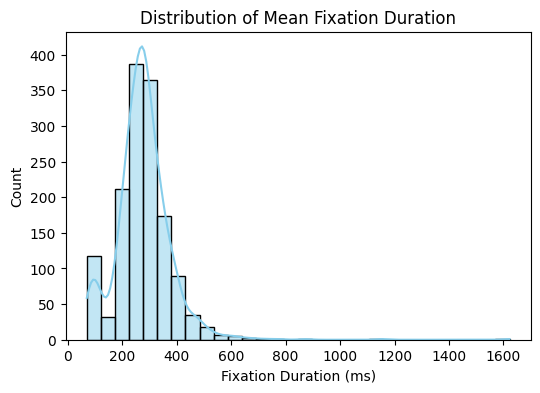

In [33]:
# Distribution of Mean Fixation Duration
plt.figure(figsize=(6,4))
sns.histplot(ivt_df['ivt_mean_fix_dur'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Mean Fixation Duration")
plt.xlabel("Fixation Duration (ms)")
plt.ylabel("Count")
plt.show()

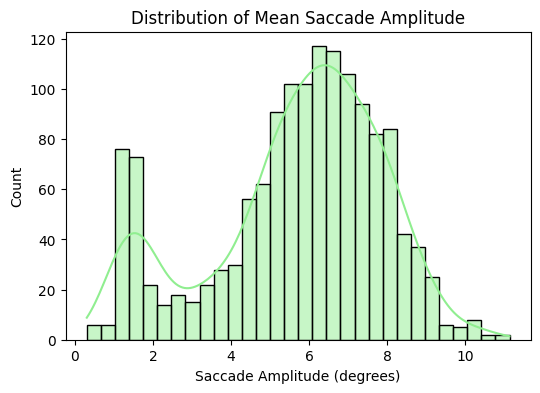

In [34]:
# Distribution of Mean Saccade Amplitude
plt.figure(figsize=(6,4))
sns.histplot(ivt_df['ivt_mean_sac_amp'], bins=30, kde=True, color='lightgreen')
plt.title("Distribution of Mean Saccade Amplitude")
plt.xlabel("Saccade Amplitude (degrees)")
plt.ylabel("Count")
plt.show()

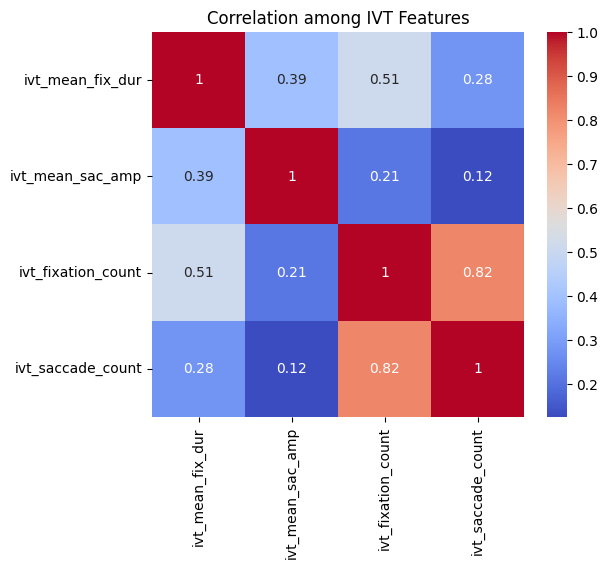

In [36]:
# Correlation Heatmap of IVT Features
plt.figure(figsize=(6,5))
sns.heatmap(ivt_df[['ivt_mean_fix_dur','ivt_mean_sac_amp','ivt_fixation_count','ivt_saccade_count']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation among IVT Features")
plt.show()

# GSR Feature Engineering

The **Galvanic Skin Response (GSR)** data represents participants' physiological arousal during mental rotation tasks.  
It is a vital modality in the **multimodal prediction pipeline**, along with **EEG, Eye-Tracking, and IVT data**, to predict whether a participant's response to a mental rotation question is **correct (1)** or **incorrect (0)**.

For this stage, the **raw GSR data was already preprocessed** during earlier steps, meaning it was in the **required format**.  
Thus, only minimal transformations were applied to ensure smooth integration into the final machine learning models.




In [37]:
gsr_file = "GSR_features.csv"
gsr_input_path = os.path.join(INPUT_DIR, gsr_file)
gsr_output_path = os.path.join(OUTPUT_DIR, "GSR_features_engineered.csv")

gsr_df = pd.read_csv(gsr_input_path, low_memory=False)

gsr_df['gsr_peak_count'] = gsr_df['gsr_peak_count'].astype(float)
gsr_df.to_csv(gsr_output_path, index=False)
print(f" GSR engineered file saved: {gsr_df.shape}")
display(gsr_df.head(10))
gsr_df.info()


 GSR engineered file saved: (1448, 8)


,Key,Participant_ID,Start_ms,End_ms,gsr_mean,gsr_max,gsr_std,gsr_peak_count
0,1spl1,1,1.680003e+12,1.680003e+12,18.241900,20.100960,1.388932,205.0
1,1spl2,1,1.680003e+12,1.680003e+12,18.086757,18.825287,0.394091,189.0
2,1Item1,1,1.680003e+12,1.680003e+12,17.447817,17.950540,0.236583,188.0
3,1Item2,1,1.680003e+12,1.680003e+12,17.714931,19.299109,0.661574,329.0
4,1Item3,1,1.680003e+12,1.680003e+12,16.470792,17.039345,0.299492,392.0
5,1Item4,1,1.680003e+12,1.680003e+12,16.930777,17.513167,0.374091,418.0
6,1Item5,1,1.680003e+12,1.680003e+12,16.684779,17.658958,0.422727,643.0
7,1Item6,1,1.680003e+12,1.680003e+12,16.158279,16.419733,0.140451,206.0
8,1Item7,1,1.680003e+12,1.680003e+12,17.238151,18.387914,0.742426,203.0
9,1Item8,1,1.680003e+12,1.680003e+12,16.924274,17.658958,0.328108,402.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Key             1448 non-null   object 
 1   Participant_ID  1448 non-null   int64  
 2   Start_ms        1448 non-null   float64
 3   End_ms          1448 non-null   float64
 4   gsr_mean        1448 non-null   float64
 5   gsr_max         1448 non-null   float64
 6   gsr_std         1448 non-null   float64
 7   gsr_peak_count  1448 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 90.6+ KB


/tmp/ipython-input-3231572113.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant_ID', y='gsr_peak_count', data=mean_peaks, palette="viridis")


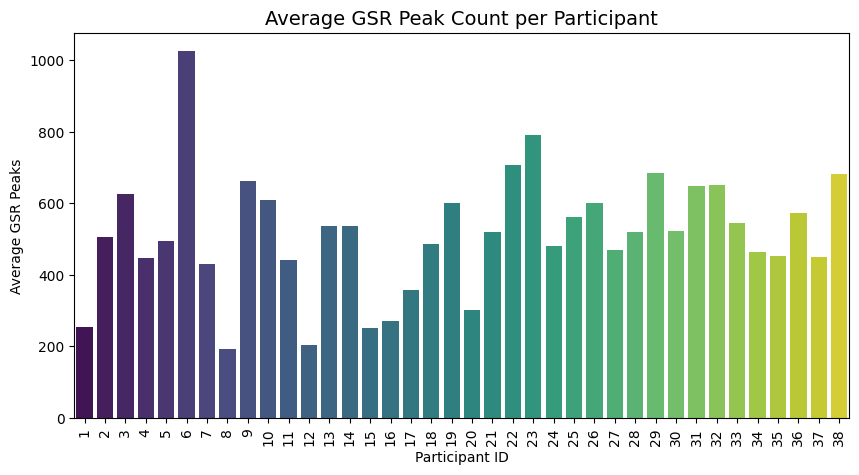

In [38]:
# Aggregating by participant to see overall physiological activity patterns.
mean_peaks = gsr_df.groupby('Participant_ID')['gsr_peak_count'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='Participant_ID', y='gsr_peak_count', data=mean_peaks, palette="viridis")
plt.title("Average GSR Peak Count per Participant", fontsize=14)
plt.xlabel("Participant ID")
plt.ylabel("Average GSR Peaks")
plt.xticks(rotation=90)
plt.show()


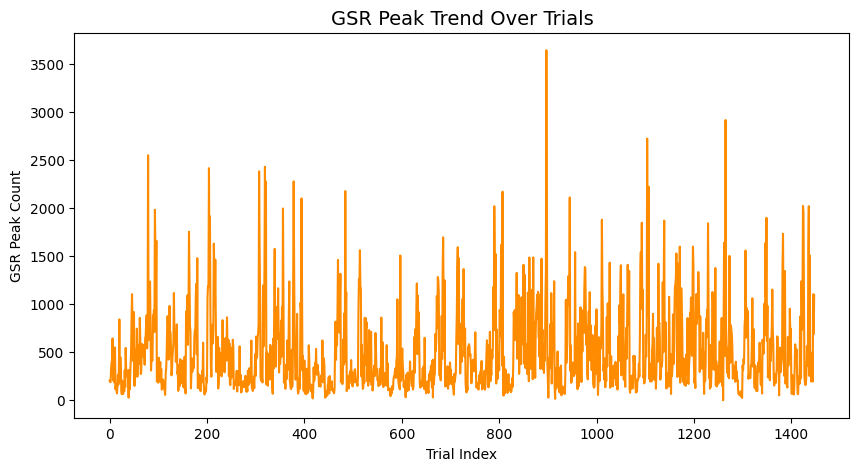

In [39]:
# Helps understand the temporal sequence and trial dynamics.
plt.figure(figsize=(10,5))
sns.lineplot(x=range(len(gsr_df)), y='gsr_peak_count', data=gsr_df, color='darkorange')
plt.title("GSR Peak Trend Over Trials", fontsize=14)
plt.xlabel("Trial Index")
plt.ylabel("GSR Peak Count")
plt.show()



## **TIVA_features_engineered.csv**

The `TIVA_features_engineered.csv` file contains **facial expression features** captured during each trial of the **mental rotation task**.  
These features represent **emotional states** and **Action Units (AUs)** that reflect facial muscle activity and emotional reactions.

Since the original TIVA data was already **preprocessed and clean**, **no additional transformations** were required.  
The file was directly saved for **downstream modeling** and multimodal data fusion.


In [41]:
tiva_file = "TIVA_features.csv"
tiva_input_path = os.path.join(INPUT_DIR, tiva_file)
tiva_output_path = os.path.join(OUTPUT_DIR, "TIVA_features_engineered.csv")

tiva_df = pd.read_csv(tiva_input_path, low_memory=False)
display(tiva_df.info())

tiva_df.to_csv(tiva_output_path, index=False)
print(f" TIVA engineered file saved: {tiva_df.shape}")
tiva_df.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1448 non-null   object 
 1   Participant_ID        1448 non-null   int64  
 2   Start_ms              1448 non-null   float64
 3   End_ms                1448 non-null   float64
 4   tiva_mean_anger       1448 non-null   float64
 5   tiva_max_anger        1448 non-null   float64
 6   tiva_mean_contempt    1448 non-null   float64
 7   tiva_max_contempt     1448 non-null   float64
 8   tiva_mean_disgust     1448 non-null   float64
 9   tiva_max_disgust      1448 non-null   float64
 10  tiva_mean_fear        1448 non-null   float64
 11  tiva_max_fear         1448 non-null   float64
 12  tiva_mean_joy         1448 non-null   float64
 13  tiva_max_joy          1448 non-null   float64
 14  tiva_mean_sadness     1448 non-null   float64
 15  tiva_max_sadness     

None

 TIVA engineered file saved: (1448, 30)


,Key,Participant_ID,Start_ms,End_ms,tiva_mean_anger,tiva_max_anger,tiva_mean_contempt,tiva_max_contempt,tiva_mean_disgust,tiva_max_disgust,...,tiva_mean_valence,tiva_max_valence,tiva_mean_confusion,tiva_max_confusion,tiva_mean_neutral,tiva_max_neutral,tiva_mean_attention,tiva_max_attention,tiva_mean_blinkrate,tiva_max_blinkrate
0,1spl1,1,1.680003e+12,1.680003e+12,0.129380,0.154047,0.192026,0.192736,0.024671,0.031868,...,0.0,0.0,0.001485,0.006085,99.600280,99.618683,97.983404,98.754173,0.000000,0.0
1,1spl2,1,1.680003e+12,1.680003e+12,0.127418,0.131842,0.191539,0.192651,0.024042,0.024329,...,0.0,0.0,0.001340,0.006678,99.616922,99.633865,97.835235,98.224716,0.000000,0.0
2,1Item1,1,1.680003e+12,1.680003e+12,0.136003,0.224068,0.189046,0.192675,0.024325,0.026854,...,0.0,0.0,0.002007,0.011253,99.596406,99.637833,97.571289,98.103561,0.000000,0.0
3,1Item2,1,1.680003e+12,1.680003e+12,0.129097,0.153570,0.191388,0.192658,0.024068,0.024661,...,0.0,0.0,0.001570,0.003732,99.617223,99.628273,97.176145,97.936546,0.000000,0.0
4,1Item3,1,1.680003e+12,1.680003e+12,0.129881,0.198665,0.190927,0.192745,0.024051,0.024756,...,0.0,0.0,0.001822,0.006987,99.616666,99.633286,96.939123,97.773972,0.689189,6.0
5,1Item4,1,1.680003e+12,1.680003e+12,0.127236,0.130569,0.192276,0.192825,0.024014,0.024213,...,0.0,0.0,0.004711,0.017874,99.615447,99.618927,97.164758,97.780205,5.024096,6.0
6,1Item5,1,1.680003e+12,1.680003e+12,0.127116,0.129228,0.191983,0.192906,0.024003,0.024049,...,0.0,0.0,0.004402,0.050763,99.616035,99.620148,97.164821,97.782486,0.000000,0.0
7,1Item6,1,1.680003e+12,1.680003e+12,0.127256,0.128067,0.191920,0.192658,0.024006,0.024061,...,0.0,0.0,0.003016,0.016845,99.616160,99.619064,97.078895,97.580734,0.000000,0.0
8,1Item7,1,1.680003e+12,1.680003e+12,0.127175,0.128463,0.192065,0.192771,0.024012,0.024066,...,0.0,0.0,0.004573,0.020225,99.615868,99.618958,96.947961,97.558403,0.000000,0.0
9,1Item8,1,1.680003e+12,1.680003e+12,0.127253,0.130509,0.191793,0.192830,0.024019,0.024097,...,0.0,0.0,0.004780,0.019989,99.616413,99.626122,97.005031,97.619049,4.318471,12.0


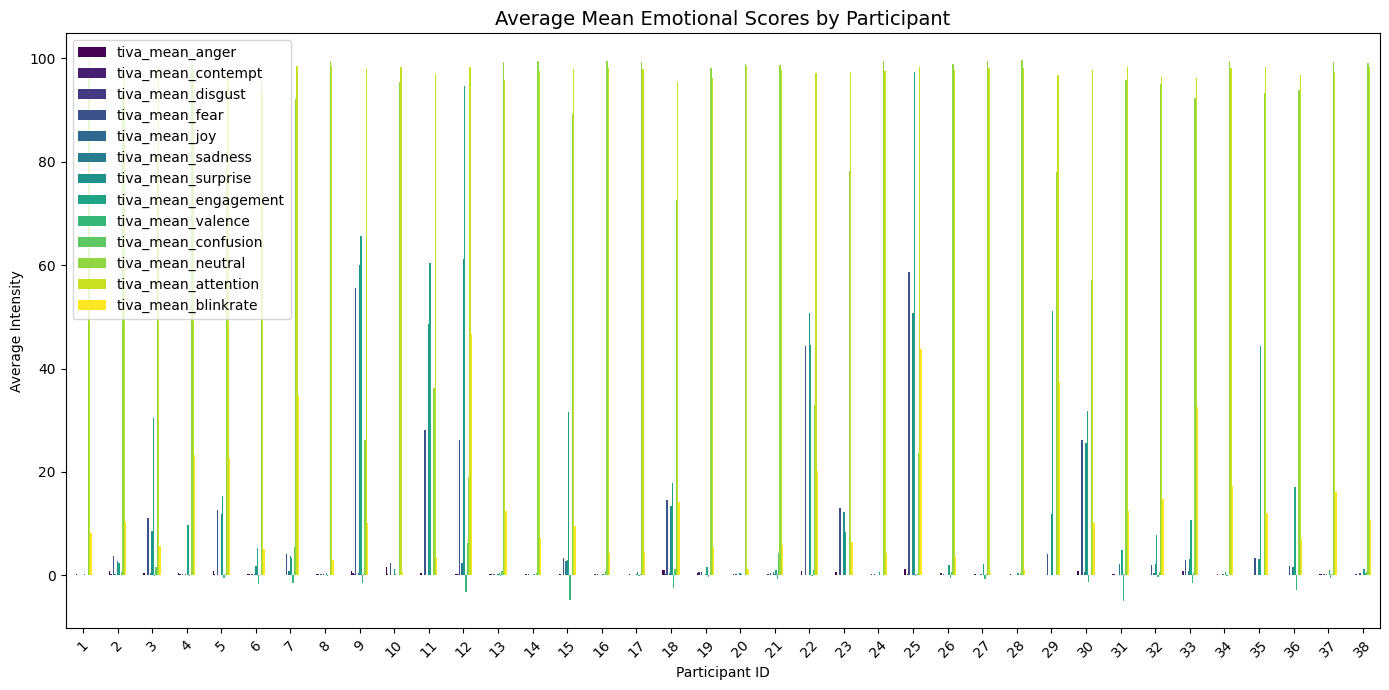

In [52]:
mean_features = [col for col in tiva_df.columns if "mean" in col]
# Average Emotion Score per Participant
avg_emotions = tiva_df.groupby("Participant_ID")[mean_features].mean()
avg_emotions.plot(kind='bar', figsize=(14, 7), colormap='viridis')
plt.title("Average Mean Emotional Scores by Participant", fontsize=14)
plt.xlabel("Participant ID")
plt.ylabel("Average Intensity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

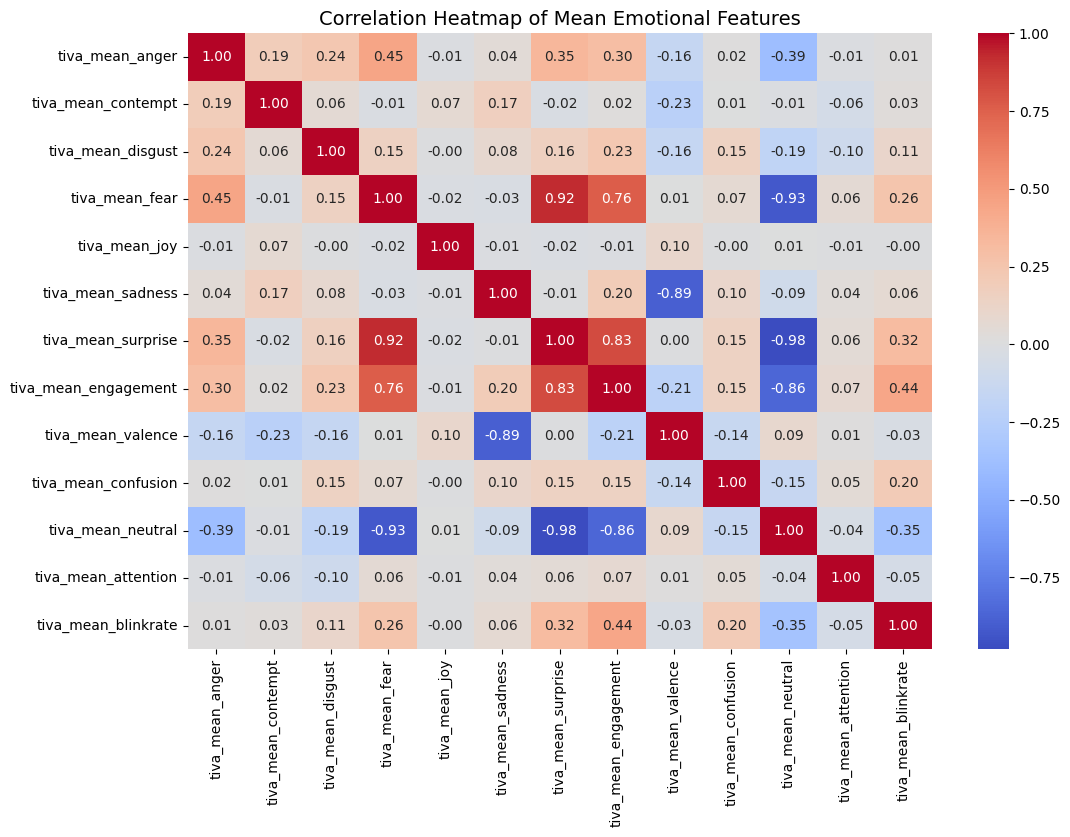

In [53]:
# Correlation Heatmap of Mean Emotions
plt.figure(figsize=(12, 8))
sns.heatmap(tiva_df[mean_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Mean Emotional Features", fontsize=14)
plt.show()

# **Multimodal Feature Merging**

This step combines all **Feature-engineered datasets** from different modalities into a **single, unified dataset**.  
The resulting dataset will be used for **multimodal machine learning models** to predict whether a participant’s response to a mental rotation task is **Correct (1)** or **Incorrect (0)**.

---

## **Problem Overview**
The project addresses the problem of **Multimodal Prediction of Mental Rotation Accuracy** by leveraging multiple types of data:

| **Modality**        | **Description**                              | **Purpose**                           |
|---------------------|----------------------------------------------|---------------------------------------|
| **EEG**             | Brain signal recordings (Delta, Theta, Alpha, Beta, Gamma) | Cognitive load and neural activity   |
| **Eye Tracking (EYE)** | Fixations, saccades, and pupil movements     | Visual attention and focus            |
| **IVT**             | Eye movement classification metrics           | Eye behavior patterns                 |
| **GSR**             | Galvanic Skin Response signals                | Physiological arousal and stress      |
| **TIVA**            | Facial expression and emotion features        | Emotional state and engagement        |
| **PSY**             | Psychological trial metadata & ground truth   | Labels and experiment context         |

The goal is to **merge these features** so that each trial is represented as a **single row** containing synchronized data from all modalities.


### **Load Engineered Data**
All final engineered files are loaded from the **feature engineering stage**:

- `PSY_features_engineered.csv`
- `EEG_features_engineered.csv`
- `EYE_features_engineered.csv`
- `IVT_features_engineered.csv`
- `GSR_features_engineered.csv`
- `TIVA_features_engineered.csv`

Each file is read into a separate dataframe for easy handling and validation.

### **Drop Unnecessary Columns**
- Columns such as **`Start_ms`** and **`End_ms`** were dropped from all files **except PSY**.
- These timestamps were **only needed during segmentation** and are no longer required for modeling.

This helps **reduce dataset size** and focus on meaningful features.


### **Merge All Modalities**
We merged all datasets **sequentially** using a **left join** on:
- **`Key`** → Represents each unique trial or question instance.
- **`Participant_ID`** → Ensures data alignment for each participant.

This ensures that **each row corresponds to one trial** with combined features across all modalities.

### **Organize Target Variable**
- The **`verdict`** column was renamed to **`Result`** for clarity.
- **`Result`** — Binary target (1 = Correct, 0 = Incorrect); trials without a response are **kept as NaN to preserve the time sequence** for future model development
- The target column was moved to the **last column** of the dataset for cleaner formatting.

This structure is **standard practice** for most machine learning pipelines.

### **Save Final Merged Dataset**
The final merged dataset is saved as:



In [54]:
import os
import pandas as pd

INPUT_DIR = "/content/drive/MyDrive/IITBinternship/FinalFeatureEngineering"

files = ["PSY_features_engineered.csv",
         "EEG_features_engineered.csv",
         "EYE_features_engineered.csv",
         "IVT_features_engineered.csv",
         "GSR_features_engineered.csv",
         "TIVA_features_engineered.csv"]

# Load all files
dfs = {}
for f in files:
    df = pd.read_csv(os.path.join(INPUT_DIR, f), low_memory=False)
    dfs[f.split("_")[0]] = df
    print(f" Loaded {f} with shape: {df.shape}")

# Drop Start_ms and End_ms from modalities except PSY
for modality in ["EEG", "EYE", "IVT", "GSR", "TIVA"]:
    dfs[modality] = dfs[modality].drop(columns=["Start_ms", "End_ms"], errors="ignore")

# Merge all on Key and Participant_ID
merged_df = dfs["PSY"]
for modality in ["EEG", "EYE", "IVT", "GSR", "TIVA"]:
    merged_df = merged_df.merge(dfs[modality], on=["Key", "Participant_ID"], how="left")

# Move 'Result' column to the end
if 'Result' in merged_df.columns:
    result_col = merged_df.pop('Result')
    merged_df['Result'] = result_col

merged_df.to_csv("/content/drive/MyDrive/IITBinternship/FinalFeatureEngineering/CompleteFeatureEngineering.csv", index=False)
print(f"Combined All features file saved: {merged_df.shape}")
tiva_df.head(10)


 Loaded PSY_features_engineered.csv with shape: (1448, 10)
 Loaded EEG_features_engineered.csv with shape: (1448, 14)
 Loaded EYE_features_engineered.csv with shape: (1448, 7)
 Loaded IVT_features_engineered.csv with shape: (1448, 8)
 Loaded GSR_features_engineered.csv with shape: (1448, 8)
 Loaded TIVA_features_engineered.csv with shape: (1448, 30)
Combined All features file saved: (1572, 57)


,Key,Participant_ID,Start_ms,End_ms,tiva_mean_anger,tiva_max_anger,tiva_mean_contempt,tiva_max_contempt,tiva_mean_disgust,tiva_max_disgust,...,tiva_mean_valence,tiva_max_valence,tiva_mean_confusion,tiva_max_confusion,tiva_mean_neutral,tiva_max_neutral,tiva_mean_attention,tiva_max_attention,tiva_mean_blinkrate,tiva_max_blinkrate
0,1spl1,1,1.680003e+12,1.680003e+12,0.129380,0.154047,0.192026,0.192736,0.024671,0.031868,...,0.0,0.0,0.001485,0.006085,99.600280,99.618683,97.983404,98.754173,0.000000,0.0
1,1spl2,1,1.680003e+12,1.680003e+12,0.127418,0.131842,0.191539,0.192651,0.024042,0.024329,...,0.0,0.0,0.001340,0.006678,99.616922,99.633865,97.835235,98.224716,0.000000,0.0
2,1Item1,1,1.680003e+12,1.680003e+12,0.136003,0.224068,0.189046,0.192675,0.024325,0.026854,...,0.0,0.0,0.002007,0.011253,99.596406,99.637833,97.571289,98.103561,0.000000,0.0
3,1Item2,1,1.680003e+12,1.680003e+12,0.129097,0.153570,0.191388,0.192658,0.024068,0.024661,...,0.0,0.0,0.001570,0.003732,99.617223,99.628273,97.176145,97.936546,0.000000,0.0
4,1Item3,1,1.680003e+12,1.680003e+12,0.129881,0.198665,0.190927,0.192745,0.024051,0.024756,...,0.0,0.0,0.001822,0.006987,99.616666,99.633286,96.939123,97.773972,0.689189,6.0
5,1Item4,1,1.680003e+12,1.680003e+12,0.127236,0.130569,0.192276,0.192825,0.024014,0.024213,...,0.0,0.0,0.004711,0.017874,99.615447,99.618927,97.164758,97.780205,5.024096,6.0
6,1Item5,1,1.680003e+12,1.680003e+12,0.127116,0.129228,0.191983,0.192906,0.024003,0.024049,...,0.0,0.0,0.004402,0.050763,99.616035,99.620148,97.164821,97.782486,0.000000,0.0
7,1Item6,1,1.680003e+12,1.680003e+12,0.127256,0.128067,0.191920,0.192658,0.024006,0.024061,...,0.0,0.0,0.003016,0.016845,99.616160,99.619064,97.078895,97.580734,0.000000,0.0
8,1Item7,1,1.680003e+12,1.680003e+12,0.127175,0.128463,0.192065,0.192771,0.024012,0.024066,...,0.0,0.0,0.004573,0.020225,99.615868,99.618958,96.947961,97.558403,0.000000,0.0
9,1Item8,1,1.680003e+12,1.680003e+12,0.127253,0.130509,0.191793,0.192830,0.024019,0.024097,...,0.0,0.0,0.004780,0.019989,99.616413,99.626122,97.005031,97.619049,4.318471,12.0


In [56]:
print("\n===== Merged Data Info =====")
print(merged_df.info())


===== Merged Data Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1572 non-null   object 
 1   Participant_ID        1572 non-null   int64  
 2   Category              1572 non-null   int64  
 3   Difficulty            1572 non-null   int64  
 4   ResponseTime          1572 non-null   float64
 5   routineStart          1572 non-null   float64
 6   routineEnd            1572 non-null   float64
 7   Start_ms              1572 non-null   float64
 8   End_ms                1572 non-null   float64
 9   eeg_mean_delta        1572 non-null   float64
 10  eeg_mean_theta        1572 non-null   float64
 11  eeg_mean_alpha        1572 non-null   float64
 12  eeg_mean_beta         1572 non-null   float64
 13  eeg_mean_gamma        1572 non-null   float64
 14  eeg_std_theta         1572 non-null   floa

In [57]:
print("\n===== Missing Values Summary =====")
print(merged_df.isna().sum())



===== Missing Values Summary =====
Key                       0
Participant_ID            0
Category                  0
Difficulty                0
ResponseTime              0
routineStart              0
routineEnd                0
Start_ms                  0
End_ms                    0
eeg_mean_delta            0
eeg_mean_theta            0
eeg_mean_alpha            0
eeg_mean_beta             0
eeg_mean_gamma            0
eeg_std_theta             0
eeg_std_alpha             0
eeg_std_beta              0
eeg_beta_alpha_ratio      0
eeg_theta_beta_ratio      0
eye_mean_pupil            0
eye_fixation_count        0
eye_gaze_dispersion       0
ivt_mean_fix_dur          0
ivt_mean_sac_amp          0
ivt_fixation_count        0
ivt_saccade_count         0
gsr_mean                  0
gsr_max                   0
gsr_std                   0
gsr_peak_count            0
tiva_mean_anger           0
tiva_max_anger            0
tiva_mean_contempt        0
tiva_max_contempt         0
tiva_mean_di

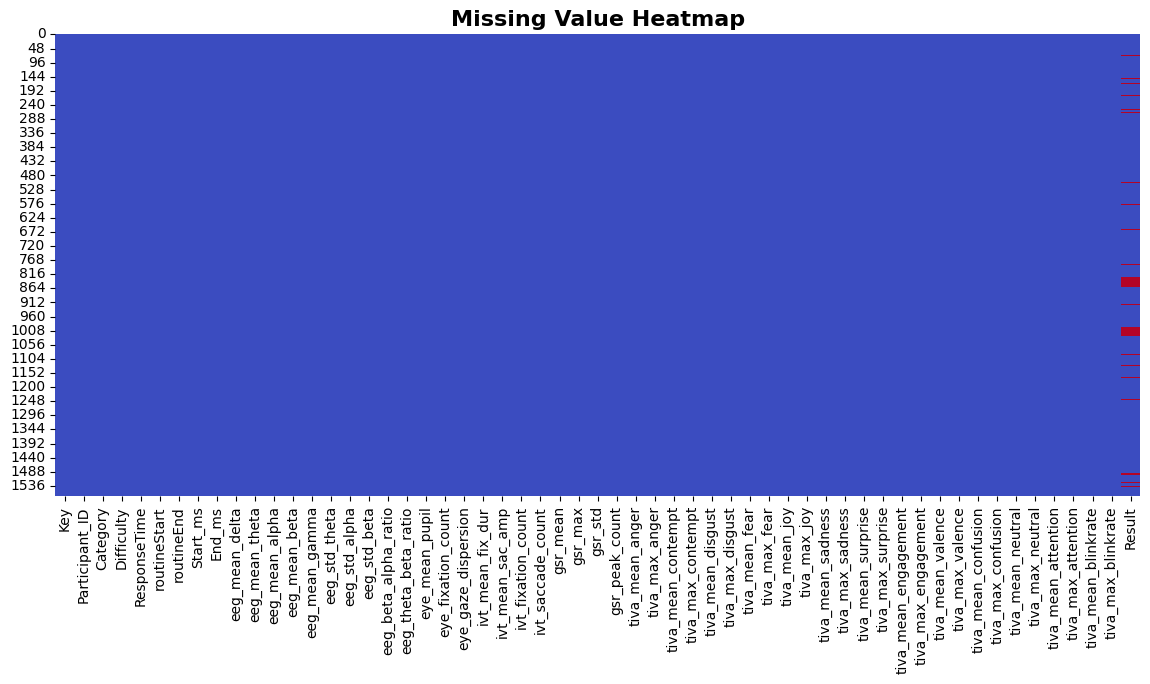

In [60]:
# Missing Value Heatmap
plt.figure(figsize=(14,6))
sns.heatmap(merged_df.isnull(), cbar=False, cmap="coolwarm")
plt.title("Missing Value Heatmap", fontsize=16, fontweight='bold')
plt.show()

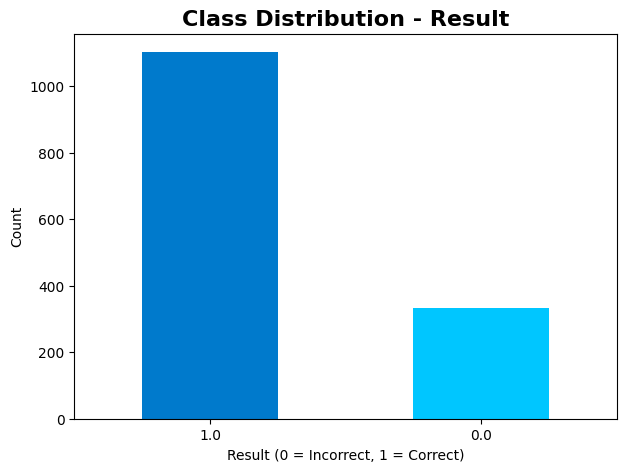

In [62]:
# Class Distribution for Target Variable
plt.figure(figsize=(7,5))
merged_df['Result'].value_counts().plot(kind='bar', color=['#007acc','#00c6ff'])
plt.title("Class Distribution - Result", fontsize=16, fontweight='bold')
plt.xlabel("Result (0 = Incorrect, 1 = Correct)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()



In [64]:
result_counts = merged_df['Result'].value_counts(dropna=False)
print("Sample counts based on Result:")
print(result_counts)

# percentage
result_percent = merged_df['Result'].value_counts(normalize=True, dropna=False) * 100
print("\nSample percentage based on Result:")
print(result_percent)

Sample counts based on Result:
Result
1.0    1103
0.0     332
NaN     137
Name: count, dtype: int64

Sample percentage based on Result:
Result
1.0    70.165394
0.0    21.119593
NaN     8.715013
Name: proportion, dtype: float64


# **Note: SMOTE & Scaling**

We have **not applied SMOTE or Standardization** at this stage.  
These steps will be done **later during model building** based on each model's needs.

- **SMOTE** will be applied **only on the training set** to balance classes and avoid data leakage.
- **Scaling** will be applied later since different models require different scaling methods:
  - StandardScaler → Neural Networks, Logistic Regression.
  - MinMaxScaler → Distance-based models like KNN.

This keeps the dataset clean and flexible for various modeling approaches.
